# EE4375-2022: Third Lab Session: Finite Difference Method for the Poisson Equation on the Unit Square

Solves the Poisson equation $- \bigtriangleup u(x,y) = f(x,uy)$ on the unit square domain $\Omega=(0,1)^2$ supplied with various boundary conditions and various source terms. The finite difference method on a uniform mesh is employed. 

## Import Packages

In [1]:
using LinearAlgebra
using SparseArrays
using Plots
using LaTeXStrings
using BenchmarkTools 

## Section 1/6: (Compulsory) First Example: Two-Dimensional Finite Difference Code

The example that follows has an analytical reference solution.   

<b> Exercises </b>: 
1. Mesh indicator matrix IG: print the matrix IG for a small mesh; understand its meaning; plot the matrix IG in such a way that its meaning becomes clear; 
2. Right-hand side vector f: print its values for a small mesh before and after the use of the reshape command; understand the use of the broadcast (with dot-syntax) to construct the right-hand side vector;
3. Kronecker product: for the construction of the matrices Axx and Ayy, the Kronecker product of matrices is used. This product is explained e.g. on https://en.wikipedia.org/wiki/Kronecker_product. Assume that $A = \begin{pmatrix} 2 & -1 \\ -1 & 2\end{pmatrix}$ and $B = \begin{pmatrix} 1 & 0 \\ 0 & 1\end{pmatrix}$. Compute $A \otimes B$ and $B \otimes A$  . Observe the size of the answer. Observe that $A \otimes B \neq B \otimes A$; extend this example to higher dimensions;  
4. Matrix Axx: print the matrix Axx for a small mesh; understand its meaning; construct an auxilary vector g that is linear in x by modifying the function sourceterm(); linear here means a polynomial of degree one in x; multiply Axx and g; observe and explain the result; 
5. Matrix Ayy: proceed as for Axx; assume the auxilary vector g to be linear in y; 
6. Computed solution u: compute and plot the finite difference solution u by solving the linear system; 
7. change the analytical reference solution and the corresponding source term;  

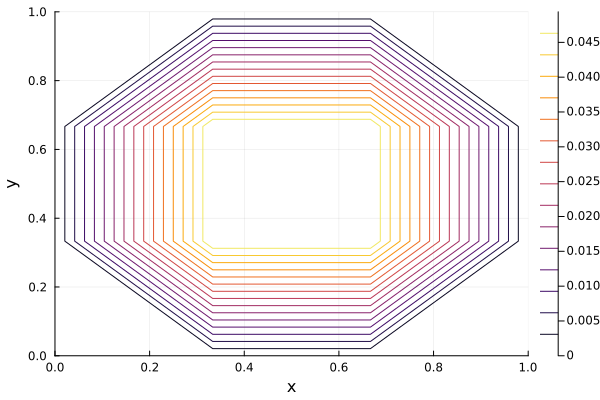

In [2]:
#..set number of intervals (N)
N = 3; 
#..compute derived numbers such as 
#..the points on the boundary (Nbnd) and the mesh width (h)
Np1 = N+1; Nm1 = N-1; Np2 = Np1*Np1; Nm2 = Nm1*Nm1; Nbnd = 4*N; h = 1/N; h2=h*h; 

#..construct the 2D mesh (X) starting from the 1D mesh (x)  
#..observe that we make in the 2D mesh the x coordinate increase from left to right and 
#..the y coordinate increase from top to bottom (as expected)
x = Vector(0:h:1); 
y = Vector(0:h:1); 
X = repeat(reshape(x, 1, :), length(y), 1);
Y = repeat(y, 1, length(x));

#..construct the mesh indicator matrix IG 
#..this indicator matrix will allow to distinguish interior and boundary nodes 
#..in this indicator matrix the boundary nodes are easy to identify 
#..for interior nodes IG(i,j) = 0 and for the boundary nodes IG(i,j) = 1
#..next construct the indicator vector IGvec by reshaping the indicator matrix IG  
IG = ones(Np1,Np1); 
IG[2:end-1,2:end-1] = zeros(Nm1,Nm1); 
IGvec = reshape(IG,Np2,1); 
#..construct array with linear indices allowing to define interior and boundary nodes 
#..interior: index array with all indices of the interior nodes 
#..boundary: index array with indices of all the boundary nodes 
L = LinearIndices(IGvec); 
interior_cartesian = findall(x->x==0,IGvec);  interior = L[interior_cartesian]; 
boundary_cartesian = findall(x->x>0,IGvec); boundary = L[boundary_cartesian]; 

#..construct auxiliary vectors used in the 1D code as well 
e = ones(Np1);            #..same as in 1D.. 
e_bnd = ones(Nbnd); #..used to handle the boundary nodes 

#..Construct one-dimensional matrix
A1 = Tridiagonal(-e[2:end], 2*e, -e[2:end]); 
A1 = (1/h2)*A1;
I = Diagonal(e); 
I_bnd = Diagonal(e_bnd); 

#..Construct the 2D matrix using Kronecker products 
Axx = kron(A1,I); 
Ayy = kron(I,A1); 
A = Axx+Ayy; 

#..Construct the right-hand side vector 
#..Define the source function 
#..Observe the use of double brackets to make f work on a tuple of coordinates (x,y)
sourceterm(x,y) = - 2*x*(x-1) - 2*y*(y-1); 
#..Evaluate fsource on each node of the grid (Xh)
#..Observe the use of the dot syntax to evaluate fsource in all mesh nodes in X 
F = sourceterm.(X,Y); 
#..Reshape the F 2D array into an f vector 
f = reshape(F,Np2); 

#..Handle the Dirichlet boundary conditions in the matrix and the right-hand side vector 
A[boundary,boundary] = I_bnd; A[boundary,interior] = zeros(Nbnd, Nm2); 
f[boundary] = zeros(Nbnd); 

#..solve the linear system for the finite difference approximation 
u = A \ f; 

#..reshape the computed approximation 
U = reshape(u,Np1,Np1); 

#..plot the computed approximation as a contour plot 
contour(x, y, U, xlabel="x", ylabel="y")

## Section 2/6: Convergence Towards the Exact Solution 

### First Study: Converge of the Numerical Solution to the Exact Solution as the Mesh is Refined

Exercises:  
1. Construct using pen and paper an analytical reference solution. This can be done for instance as follows. Assume first that $u(x,y) = \text{whatever-you-like}(x,y) \, x \, (x-1) \, y \, (y-1)$ where $\text{whatever-you-like}(x,y)$ is any function in $x$ and $y$. The multiplication with $x$, $x-1$, $y$ and $y-1$ is such that the function $u(x,y)$ satisfies the Dirichlet boundary conditions. Next compute $f(x,y)$ by computing $-\bigtriangleup u(x,y)$. The function $f(x,y)$ can subsequently be used as source function in the finite difference code;   
2. Verify that the difference between the analytical reference solution and the numerically computed solution decreases as the mesh is refined; 

### Second Study: Converge of the Numerical Solution to the Exact Solution as the Polynomial Degree of the Appproximation is Increased 

Replace code as above by code that employ DiffEqOperators.jl https://diffeqoperators.sciml.ai/stable/. 

## Section 3/6: A Closer Look into the Linear Algebra

### First Study: dense vs. sparse 

Compare runtime of solver with A dense and A sparse. The sparse command allow to convert from dense to sparse. Use the @btime macro to compare both variants.

### (experimental) Second Study: direct vs. iterative

Compare runtime of solver using direct and iterative (CG preconditioned by for instance algebraic multigrid) for various problem sizes.

## Section (4/6): An Application: Coil in Air 

### Computation of the potential 

In [ ]:
#..set number of intervals (N)
N = 50; 
#..compute derived numbers such as 
#..the points on the boundary (Nbnd) and the mesh width (h)
Np1 = N+1; Nm1 = N-1; Np2 = Np1*Np1; Nm2 = Nm1*Nm1; Nbnd = 4*N; h = 1/N; h2=h*h; 

#..construct the 2D mesh (X) starting from the 1D mesh (x)  
#..observe that we make in the 2D mesh the x coordinate increase from left to right and 
#..the y coordinate increase from top to bottom (as expected)
x = Vector(0:h:1); 
y = Vector(0:h:1); 
X = repeat(reshape(x, 1, :), length(y), 1);
Y = repeat(y, 1, length(x));

#..construct the mesh indicator matrix IG 
#..this indicator matrix will allow to distinguish interior and boundary nodes 
#..in this indicator matrix the boundary nodes are easy to identify 
#..for interior nodes IG(i,j) = 0 and for the boundary nodes IG(i,j) = 1
#..next construct the indicator vector IGvec by reshaping the indicator matrix IG  
IG = ones(Np1,Np1); 
IG[2:end-1,2:end-1] = zeros(Nm1,Nm1); 
IGvec = reshape(IG,Np2,1); 
#..construct array with linear indices allowing to define interior and boundary nodes 
#..interior: index array with all indices of the interior nodes 
#..boundary: index array with indices of all the boundary nodes 
L = LinearIndices(IGvec); 
interior_cartesian = findall(x->x==0,IGvec);  interior = L[interior_cartesian]; 
boundary_cartesian = findall(x->x>0,IGvec); boundary = L[boundary_cartesian]; 

#..construct auxiliary vectors used in the 1D code as well 
e = ones(Np1);            #..same as in 1D.. 
e_bnd = ones(Nbnd); #..used to handle the boundary nodes 

#..Construct one-dimensional matrix
A1 = Tridiagonal(-e[2:end], 2*e, -e[2:end]); 
A1 = (1/h2)*A1;
I = Diagonal(e); 
I_bnd = Diagonal(e_bnd); 

#..Construct the 2D matrix using Kronecker products 
A = kron(A1,I) + kron(I,A1); 

#..Construct the right-hand side vector 
#..Define the source function 
#..Observe the use of double brackets to make f work on a tuple of coordinates (x,y)
sourceterm(x,y) = (x.>=.35).*(x.<=.45).*(y.>=.45).*(y.<=.55) .- (x.>=.55).*(x.<=.65).*(y.>=.45).*(y.<=.55); 
#..Evaluate fsource on each node of the grid (Xh)
#..Observe the use of the dot syntax to evaluate fsource in all mesh nodes in X 
F = sourceterm.(X,Y); 
#..Reshape the F 2D array into an f vector 
f = reshape(F,Np2); 

#..Handle the Dirichlet boundary conditions in the matrix and the right-hand side vector 
A[boundary,boundary] = I_bnd; A[boundary,interior] = zeros(Nbnd, Nm2); 
f[boundary] = zeros(Nbnd); 

#..solve the linear system for the finite difference approximation 
u = A \ f; 

#..reshape the computed approximation 
U = reshape(u,Np1,Np1); 

#..plot the computed approximation as a contour plot 
contour(x, y, U, xlabel="x", ylabel="y")

### (in development): Computation of the flux 

The flux is computed as the gradient of the potential. Details are to be filled in. 

In [50]:
#..set number of intervals (N)
N = 50; 
#..compute derived numbers such as 
#..the points on the boundary (Nbnd) and the mesh width (h)
Np1 = N+1; Nm1 = N-1; Np2 = Np1*Np1; Nm2 = Nm1*Nm1; Nbnd = 4*N; h = 1/N; h2=h*h; 

#..construct the 2D mesh (X) starting from the 1D mesh (x)  
#..observe that we make in the 2D mesh the x coordinate increase from left to right and 
#..the y coordinate increase from top to bottom (as expected)
x = Vector(0:h:1); 
y = Vector(0:h:1); 
X = repeat(reshape(x, 1, :), length(y), 1);
Y = repeat(y, 1, length(x));
xmid = x[1:end-1].+h/2; 
ymid = y[1:end-1].+h/2; 

#..construct the mesh indicator matrix IG 
#..this indicator matrix will allow to distinguish interior and boundary nodes 
#..in this indicator matrix the boundary nodes are easy to identify 
#..for interior nodes IG(i,j) = 0 and for the boundary nodes IG(i,j) = 1
#..next construct the indicator vector IGvec by reshaping the indicator matrix IG  
IG = ones(Np1,Np1); 
IG[2:end-1,2:end-1] = zeros(Nm1,Nm1); 
IGvec = reshape(IG,Np2,1); 
#..construct array with linear indices allowing to define interior and boundary nodes 
#..interior: index array with all indices of the interior nodes 
#..boundary: index array with indices of all the boundary nodes 
L = LinearIndices(IGvec); 
interior_cartesian = findall(x->x==0,IGvec);  interior = L[interior_cartesian]; 
boundary_cartesian = findall(x->x>0,IGvec); boundary = L[boundary_cartesian]; 

#..construct auxiliary vectors used in the 1D code as well 
e = ones(Np1);            #..same as in 1D.. 
e_bnd = ones(Nbnd); #..used to handle the boundary nodes 

#..Construct one-dimensional matrix
A1 = Tridiagonal(-e[2:end], 2*e, -e[2:end]); 
A1 = (1/h2)*A1;
I = Diagonal(e); 
I_bnd = Diagonal(e_bnd); 

#..construct the matrix enabling the computation of ux and uy  
#..we use comprehension to construct the rectangular matrix B 
B = [i==j ? -1/h : i==j-1 ? 1/h : 0 for i = 1:N, j=1:Np1]

#..Construct the 2D matrix using Kronecker products 
A = kron(A1,I) + kron(I,A1); 
Bx = kron(B,I);
By = kron(I,B);

#..Construct the right-hand side vector 
#..Define the source function 
#..Observe the use of double brackets to make f work on a tuple of coordinates (x,y)
sourceterm(x,y) = (x.>=.35).*(x.<=.45).*(y.>=.45).*(y.<=.55) .- (x.>=.55).*(x.<=.65).*(y.>=.45).*(y.<=.55); 
#..Evaluate fsource on each node of the grid (Xh)
#..Observe the use of the dot syntax to evaluate fsource in all mesh nodes in X 
F = sourceterm.(X,Y); 
#..Reshape the F 2D array into an f vector 
f = reshape(F,Np2); 

#..Handle the Dirichlet boundary conditions in the matrix and the right-hand side vector 
A[boundary,boundary] = I_bnd; A[boundary,interior] = zeros(Nbnd, Nm2); 
f[boundary] = zeros(Nbnd); 

#..solve the linear system for the finite difference approximation 
u = A \ f; 
ux = Bx*u; 
uy = By*u; 

#..reshape the computed approximation 
#..observe the fact that Ux and Uy live on a coarser mesh 
U = reshape(u,Np1,Np1); 
Ux = reshape(ux,Np1,N); 
Uy = reshape(uy,N,Np1); 

#..plot the computed approximation as a contour plot 
#p1 = contour(x, y, U, xlabel="x", ylabel="y")

p2 = heatmap(Ux, xlabel="x", ylabel="y")

p3 = heatmap(Uy, xlabel="x", ylabel="y")

p4 = quiver(Ux, Uy) 

plot(p1,p2,p3,p4,layout=(4,1))

LoadError: Cannot convert Matrix{Any} to series data for plotting

## Section 5/6: A Closer Look into Julia

In both the second and third lab session, we saw the use of broadcast (with dot-syntax) to apply a function (the source function) to a set of points (the mesh). This notion extends in Julia by so-called iterable collections and the function map. More information is provided e.g. here https://docs.julialang.org/en/v1/base/collections/#Iterable-Collections .   

## Section 6/6: References

1. The finite difference method on wikipedia [wiki](https://en.wikipedia.org/wiki/Finite_difference_method). Especially Section 5 of this page is revelant here. 
2. The construction of the matrix $A$ using the sum of two Kronecker products is described on https://en.wikipedia.org/wiki/Kronecker_sum_of_discrete_Laplacians. 

## Sandbox

### Eigenvalues and positive definiteness of matrices 

In [6]:
# construct 5-by-5 example for A 
# and check whether A is positive definite 
A = [1 0 0 0 0; -1 2 -1 0 0; 0 -1 2 -1 0; 0 0 -1 2 -1; 0 0 0 0 1]
isposdef(A)

false

In [7]:
eigvals(A)

5-element Vector{Float64}:
 0.5857864376269047
 1.0
 1.0
 1.9999999999999993
 3.4142135623730914

In [8]:
Amod = [1 0 0 0 0; 0 2 -1 0 0; 0 -1 2 -1 0; 0 0 -1 2 0; 0 0 0 0 1]
isposdef(Amod)

true

In [9]:
eigvals(A)

5-element Vector{Float64}:
 0.5857864376269047
 1.0
 1.0
 1.9999999999999993
 3.4142135623730914

### More on LinearIndices

In [10]:
A = [10 20; 30 40]
IG = LinearIndices(A)

2×2 LinearIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}:
 1  3
 2  4

In [3]:
?LinearIndices

search: LinearIndices



```
LinearIndices(A::AbstractArray)
```

Return a `LinearIndices` array with the same shape and [`axes`](@ref) as `A`, holding the linear index of each entry in `A`. Indexing this array with cartesian indices allows mapping them to linear indices.

For arrays with conventional indexing (indices start at 1), or any multidimensional array, linear indices range from 1 to `length(A)`. However, for `AbstractVector`s linear indices are `axes(A, 1)`, and therefore do not start at 1 for vectors with unconventional indexing.

Calling this function is the "safe" way to write algorithms that exploit linear indexing.

# Examples

```jldoctest
julia> A = fill(1, (5,6,7));

julia> b = LinearIndices(A);

julia> extrema(b)
(1, 210)
```

```
LinearIndices(inds::CartesianIndices) -> R
LinearIndices(sz::Dims) -> R
LinearIndices((istart:istop, jstart:jstop, ...)) -> R
```

Return a `LinearIndices` array with the specified shape or [`axes`](@ref).

# Example

The main purpose of this constructor is intuitive conversion from cartesian to linear indexing:

```jldoctest
julia> linear = LinearIndices((1:3, 1:2))
3×2 LinearIndices{2, Tuple{UnitRange{Int64}, UnitRange{Int64}}}:
 1  4
 2  5
 3  6

julia> linear[1,2]
4
```
